In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.lines import Line2D


# Barrier Options and Monte Carlo Pricing with GBM

## What is a Barrier Option?

A **barrier option** is a type of **exotic option** whose payoff depends on whether the underlying asset's price reaches or breaches a predetermined barrier level during the option's life. Barrier options can be classified into two main types:

1. **Knock-In Options**: The option becomes active only if the underlying asset's price breaches the barrier.
2. **Knock-Out Options**: The option becomes void if the underlying asset's price breaches the barrier.

For example, an **up-and-out barrier call option** is a knock-out option where the option becomes worthless if the underlying asset's price rises above the barrier level at any point before expiration.

---

## Pricing Barrier Options Using Monte Carlo Simulation

Barrier options are often priced using **Monte Carlo simulation** when closed-form solutions are unavailable. The process involves simulating multiple paths of the underlying asset's price using **Geometric Brownian Motion (GBM)** and calculating the option's payoff for each path.

### Steps to Price a Barrier Option with Monte Carlo:

1. **Simulate GBM Paths**:
   - Use the GBM stochastic differential equation to generate multiple price paths for the underlying asset.
   - Incorporate the risk-neutral measure by setting the drift to the risk-free rate \( r \).

2. **Check Barrier Breach**:
   - For each simulated path, check if the underlying asset's price breaches the barrier level during the option's life.

3. **Calculate Payoffs**:
   - For paths where the barrier is not breached, calculate the option's payoff at maturity (e.g., \( \max(S_T - K, 0) \) for a call option).
   - For paths where the barrier is breached, the payoff is \( 0 \).

4. **Discount Payoffs**:
   - Discount the average payoff across all paths to the present value using the risk-free rate \( r \).

### Advantages of Monte Carlo Simulation:
- It can handle complex option structures, such as path-dependent options like barrier options.
- It provides flexibility to model various market conditions and assumptions.

### Example:
For an **up-and-out barrier call option**, the payoff is calculated as:
$$
\text{Payoff} = 
\begin{cases} 
\max(S_T - K, 0) & \text{if } S_t \leq B \text{ for all } t \in [0, T] \\
0 & \text{if } S_t > B \text{ for any } t \in [0, T]
\end{cases}
$$
Where:
- $S_T$: Underlying asset price at maturity
- $K$: Strike price
- $B$: Barrier level
- $T$: Time to maturity

Monte Carlo simulation is used to estimate the expected discounted payoff by averaging the results over many simulated paths.

In [3]:
def up_and_out_barrier_call(S0, K, T, r, sigma, B, M=10000, N=252, random_seed=None):
    """
    Price an up-and-out barrier call option using Monte Carlo simulation.

    Parameters:
    S0 (float): Initial stock price
    K (float): Strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate (annualized)
    sigma (float): Volatility of the underlying asset (annualized)
    B (float): Barrier level (up-and-out)
    M (int): Number of Monte Carlo simulations
    N (int): Number of time steps
    random_seed (int): Seed for random number generator

    Returns:
    float: Estimated price of the up-and-out barrier call option
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    dt = T / N  # Time step
    discount_factor = np.exp(-r * T)  # Discount factor for present value

    # Simulate M paths of GBM
    S = np.zeros((N + 1, M))
    S[0] = S0
    for t in range(1, N + 1):
        Z = np.random.normal(0, 1, M)  # Standard normal random variables
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Check if the barrier is breached
    breached = np.any(S > B, axis=0)

    # Calculate payoffs for paths that did not breach the barrier
    payoffs = np.where(~breached, np.maximum(S[-1] - K, 0), 0)

    # Calculate the option price
    option_price = discount_factor * np.mean(payoffs)
    return option_price

# Example usage
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to maturity (in years)
r = 0.05    # Risk-free rate
sigma = 0.2 # Volatility
B = 140     # Barrier level
M = 10000   # Number of Monte Carlo simulations

barrier_call_price = up_and_out_barrier_call(S0, K, T, r, sigma, B, M, random_seed=42)
print(f"Up-and-Out Barrier Call Option Price: ${barrier_call_price:.2f}")

Up-and-Out Barrier Call Option Price: $5.95


## We can visualise the pricing of an Up-and-Out Barrier Call

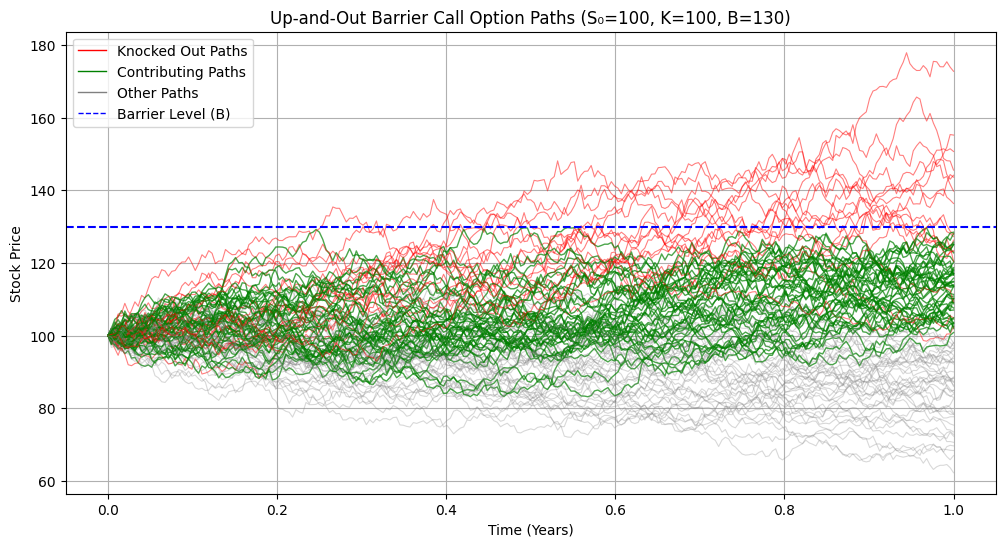

In [6]:
def visualize_up_and_out_barrier_call(S0, K, T, r, sigma, B, M=100, N=252, random_seed=None):
    """
    Visualize the paths used to price an up-and-out barrier call option.

    Parameters:
    S0 (float): Initial stock price
    K (float): Strike price
    T (float): Time to maturity (in years)
    r (float): Risk-free interest rate (annualized)
    sigma (float): Volatility of the underlying asset (annualized)
    B (float): Barrier level (up-and-out)
    M (int): Number of Monte Carlo simulations
    N (int): Number of time steps
    random_seed (int): Seed for random number generator
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    dt = T / N  # Time step
    t = np.linspace(0, T, N + 1)  # Time points

    # Simulate M paths of GBM
    S = np.zeros((N + 1, M))
    S[0] = S0
    for i in range(1, N + 1):
        Z = np.random.normal(0, 1, M)  # Standard normal random variables
        S[i] = S[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Determine which paths are knocked out
    breached = np.any(S > B, axis=0)

    # Determine which paths contribute to the option value
    in_the_money = (S[-1] > K) & ~breached

    # Plot the paths
    plt.figure(figsize=(12, 6))
    for j in range(M):
        if breached[j]:
            plt.plot(t, S[:, j], color='red', alpha=0.5, linewidth=0.8)  # Knocked out paths
        elif in_the_money[j]:
            plt.plot(t, S[:, j], color='green', alpha=0.7, linewidth=1.0)  # Contributing paths
        else:
            plt.plot(t, S[:, j], color='grey', alpha=0.3, linewidth=0.8)  # Other paths

    # Plot the barrier level
    plt.axhline(y=B, color='blue', linestyle='--', linewidth=1.5, label='Barrier Level (B)')

    # Create a custom legend
    legend_elements = [
        Line2D([0], [0], color='red', lw=1, label='Knocked Out Paths'),
        Line2D([0], [0], color='green', lw=1, label='Contributing Paths'),
        Line2D([0], [0], color='grey', lw=1, label='Other Paths'),
        Line2D([0], [0], color='blue', lw=1, linestyle='--', label='Barrier Level (B)')
    ]
    plt.legend(handles=legend_elements, loc="upper left")

    # Add labels and legend
    plt.title(f"Up-and-Out Barrier Call Option Paths (S₀={S0}, K={K}, B={B})")
    plt.xlabel("Time (Years)")
    plt.ylabel("Stock Price")
    plt.grid(True)
    plt.show()

# Example usage
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to maturity (in years)
r = 0.05    # Risk-free rate
sigma = 0.2 # Volatility
B = 130     # Barrier level
M = 100     # Number of Monte Carlo simulations

visualize_up_and_out_barrier_call(S0, K, T, r, sigma, B, M, random_seed=42)